In [1]:
import os
os.environ['PYOPENGL_PLATFORM']='osmesa'

import argparse
import pickle
import sys
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
# from gta_utils import LIMBS, read_depthmap
# from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob


import argparse

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import sys
sys.path.append('../')
sys.path.append('../../src')

from benji_prox_dataloader import *
from utils import *
from visualisation import *
from simple_transformer import PoseTransformer
import torch


import wandb
from scipy.ndimage import gaussian_filter1d



numpy: 1.22.3


In [2]:
import wandb
run_path = "vh-motion-pred/rnn/6n2zto4b"
api = wandb.Api()
run = api.run(run_path)

save_path = 'saves/GRU_joints_15_30_3fps_24_05_1854_epoch199_bn39.pt'
wandb.restore(save_path, run_path=run_path)

gru = PoseGRU_inputFC2(input_size=(25,3))
restore_dict = torch.load(save_path)
gru.load_state_dict(restore_dict['model_state_dict'])

<_io.TextIOWrapper name='/cluster/home/bdayan/prox/prox/virtual_huams_resource/notebooks_neat/saves/GRU_joints_15_30_3fps_24_05_1854_epoch199_bn39.pt' mode='r' encoding='UTF-8'>

<All keys matched successfully>

In [3]:

# root_dir = "D:/prox_data"
root_dir = "/cluster/scratch/bdayan/prox_data"

smplx_model_path='../../models_smplx_v1_1/models/'
in_frames=15
pred_frames=30
frame_jump=10
window_overlap_factor=8
lr = 0.0001
n_iter = 100

#PROXD_attempt2
pd = proxDatasetJoints(root_dir=root_dir + '/PROXD', in_frames=in_frames, pred_frames=pred_frames, \
                       output_type='joint_locations', smplx_model_path=smplx_model_path, frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)
pdc = DatasetBase(root_dir=root_dir + '/recordings', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='Color', extra_prefix='', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)
pd2 = DatasetBase(root_dir=root_dir + '/PROXD', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='results', extra_prefix='joints_worldnorm.pkl', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)


print(len(pd), len(pdc))
pd.align(pdc)
pdc.align(pd)
print(len(pd), len(pdc))
pd2.align(pd)
pd.align(pd2)
print(len(pd), len(pd2))

# pdi = proxDatasetImages(root_dir="/cluster/scratch/bdayan/prox_data/recordings", in_frames=in_frames, pred_frames=pred_frames)

# dataloader = DataLoader(pd, batch_size=batch_size,
#                         shuffle=True, num_workers=0, collate_fn=my_collate)

1150 1338
1169 1169
1169 1169


In [4]:
pd.output_type = 'joint_locations'
idx, in_joint_locations, pred_joint_locations = pd.__getitem__(50)
pd.output_type = 'raw_pkls'
(idx, (in_joint_fns, in_joint_data), (pred_joint_fns, pred_joint_data)) = pd.__getitem__(50)
in_frames_dicts, in_frames_fns, pred_frames_dicts, pred_frames_fns = pdc.__getitem__(50)
in_pkl_fns, in_pkls, pred_pkl_fns, pred_pkls = pd2.__getitem__(50)
in_skels_pkls, pred_skels_pkls = list(map(load, in_pkls)), list(map(load, pred_pkls))

in_frames = [np.array(cv2.imread(fn)) for fn in in_frames_fns]
pred_frames = [np.array(cv2.imread(fn)) for fn in pred_frames_fns]

In [5]:
import json

in_skels_pkls, fut_skels_pkls = list(map(load, in_pkls)), list(map(load, pred_pkls))
in_skels_world = torch.cat(in_skels_pkls)
fut_skels_world = torch.cat(pred_skels_pkls)

with open(root_dir + '/cam2world/MPH1Library.json') as file:
    cam2world = np.array(json.load(file))
    cam2world = torch.from_numpy(cam2world).float()

In [6]:
images = in_frames + pred_frames

output_images = predict_and_visualise(gru, in_skels_world, fut_skels_world, images, cam2world)

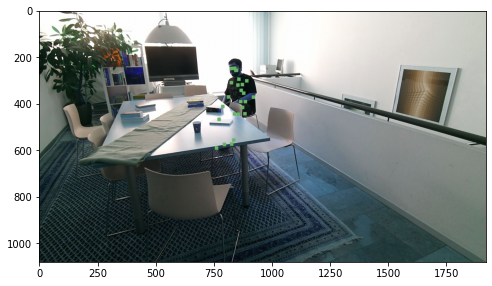

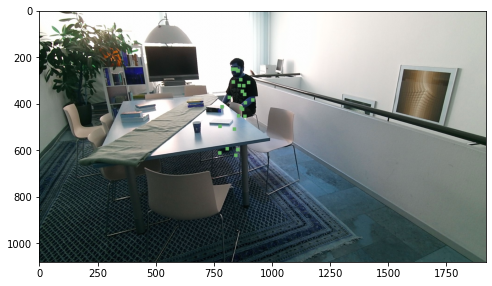

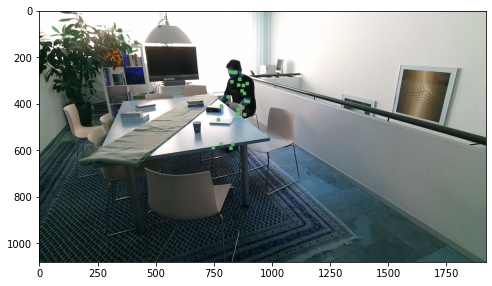

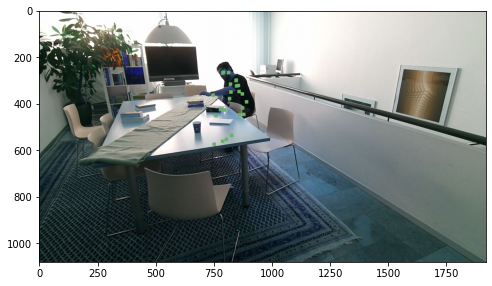

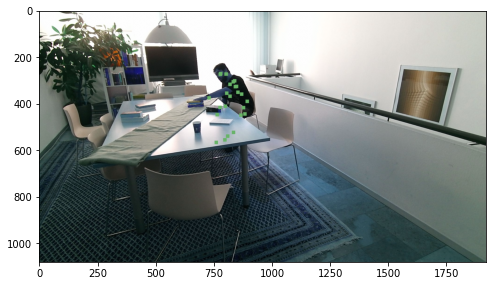

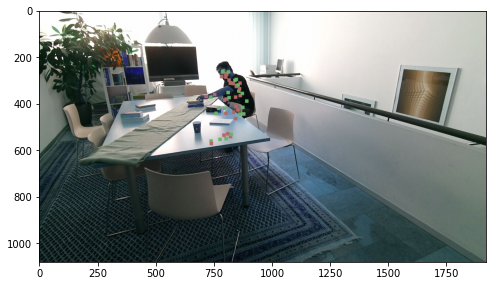

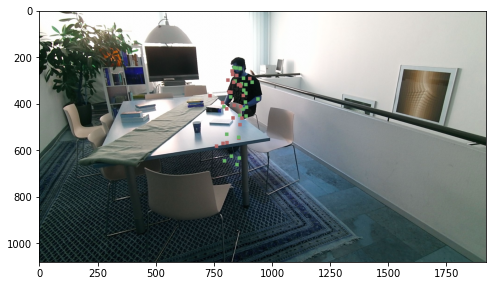

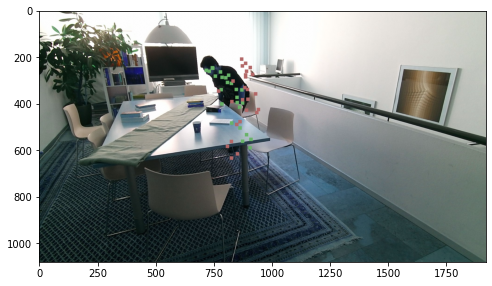

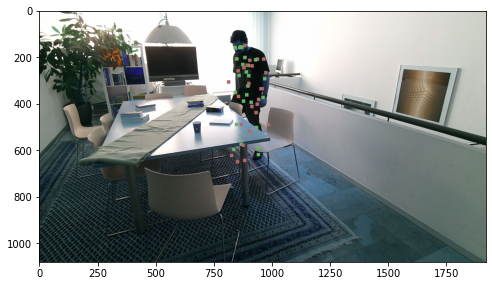

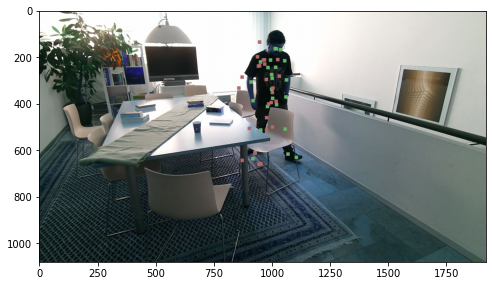

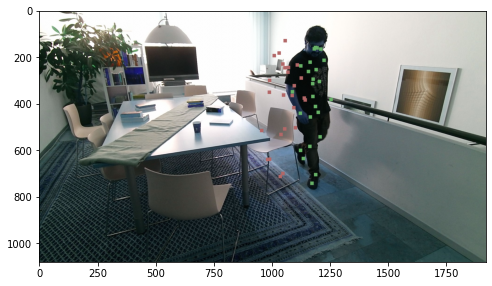

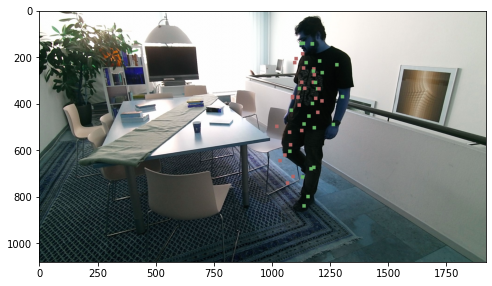

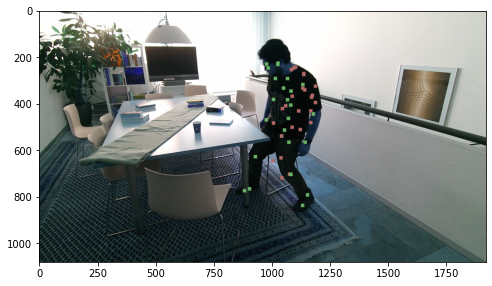

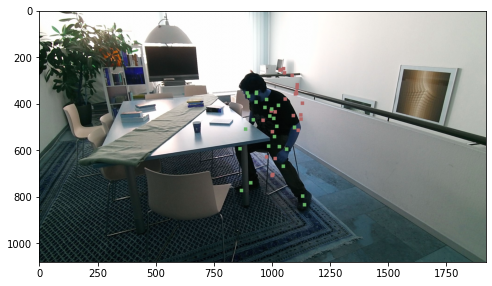

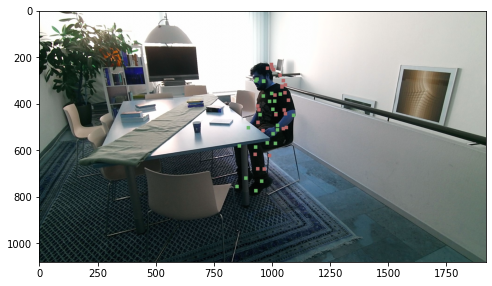

In [7]:
for img in output_images[::3]:
    _ = plt.figure(figsize=(8,8))
    _ = plt.imshow(img)

In [ ]:
for img in output_images[::3]:
    _ = plt.figure(figsize=(8,8))
    _ = plt.imshow(img)